<a href="https://colab.research.google.com/github/capofwesh20/Analysis-of-NHTSA-complaints/blob/main/Associative_Mining.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [17]:
%%capture
!pip install fpgrowth_py
!pip install wordcloud

Not all entries might have accurately labeled component descriptions, or some complaints might involve multiple components. Topic modeling can help identify such cases by grouping complaints into topics based on the textual content of the complaints themselves, offering a way to check and refine the categorization of complaints.

Topic modeling can help identify new or emerging trends in vehicle complaints that might not yet be well-represented in your component descriptions. This can be particularly valuable for detecting new issues early on.

mproving Customer Service and Product Development:
Understanding the variety and frequency of topics discussed in complaints can inform customer service strategies and product development. It helps prioritize issues that are most significant to customers and identify areas for improvement in vehicle design and features.

context, severity, and user sentiments
The topics derived from modeling can enrich your dataset by adding another layer of categorization. This can be useful for subsequent analyses, such as trend analysis over time or comparative analysis across vehicle models.

In [3]:
%matplotlib inline
import matplotlib
import matplotlib.pyplot as plt
from matplotlib import colors
import pandas as pd
import numpy as np
import seaborn as sns
from mpl_toolkits.mplot3d import Axes3D
from matplotlib.colors import ListedColormap
import pandas as pd
from tqdm.auto import tqdm
tqdm.pandas()  # Prepare tqdm to work with pandas apply()
import spacy
from collections import Counter
import fpgrowth_py.fpgrowth as fpgrowth

In [4]:
df = pd.read_csv('/content/drive/MyDrive/Classroom/modified_data.csv')

In [ ]:
df.head()

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


,Complain ID,MANUFACTURER'S NAME,VEHICLE MAKE,VEHICLE MODEL,MODEL YEAR,WAS VEHICLE INVOLVED IN A CRASH,WAS VEHICLE INVOLVED IN A FIRE,NUMBER OF PERSONS INJURED,NUMBER OF FATALITIES,SPECIFIC COMPONENT'S DESCRIPTION,CONSUMER'S CITY,CONSUMER'S STATE CODE,VEHICLE MILEAGE AT FAILURE,DESCRIPTION OF THE COMPLAINT,WAS INCIDENT REPORTED TO POLICE,ANTI-LOCK BRAKES,CRUISE CONTROL,VEHICLE SPEED,WAS VEHICLE TOWED,Year
0,1633294,Honda (American Honda Motor Co.),HONDA,ACCORD,2018.0,N,N,0,0,SERVICE BRAKES,PHILADELPHIA,PA,4.0,"DRIVING AT THE HIGHWAY, CAR SUDDENLY SLOW DOWN...",N,N,N,68.0,N,2019
1,1633295,Honda (American Honda Motor Co.),HONDA,ACCORD,2018.0,N,N,0,0,ELECTRICAL SYSTEM,PHILADELPHIA,PA,4.0,"DRIVING AT THE HIGHWAY, CAR SUDDENLY SLOW DOWN...",N,N,N,68.0,N,2019
2,1633296,Honda (American Honda Motor Co.),HONDA,ACCORD,2018.0,N,N,0,0,ENGINE,PHILADELPHIA,PA,4.0,"DRIVING AT THE HIGHWAY, CAR SUDDENLY SLOW DOWN...",N,N,N,68.0,N,2019
3,1633297,Ford Motor Company,FORD,EXPLORER,2020.0,N,N,0,0,ELECTRICAL SYSTEM,MEHERRIN,VA,5300.0,DEEP SLEEP MODE ACTIVATES AFTER 2 DAYS. MOST ...,N,N,N,0.0,N,2019
4,1633298,"General Motors, LLC",CHEVROLET,VOLT,2017.0,N,N,0,0,SERVICE BRAKES,SAN ANTONIO,TX,15000.0,"WHILE DRIVING ON CITY STREETS AND HIGHWAYS, TH...",N,N,N,70.0,N,2019


In [23]:
df.shape

(1448058, 20)

In [5]:
selected_df = df[['Complain ID', 'VEHICLE MAKE', 'VEHICLE MODEL', 'DESCRIPTION OF THE COMPLAINT', 'SPECIFIC COMPONENT\'S DESCRIPTION']]


In [ ]:
selected_df.head()

,Complain ID,VEHICLE MAKE,VEHICLE MODEL,DESCRIPTION OF THE COMPLAINT,SPECIFIC COMPONENT'S DESCRIPTION
0,1633294,HONDA,ACCORD,"DRIVING AT THE HIGHWAY, CAR SUDDENLY SLOW DOWN...",SERVICE BRAKES
1,1633295,HONDA,ACCORD,"DRIVING AT THE HIGHWAY, CAR SUDDENLY SLOW DOWN...",ELECTRICAL SYSTEM
2,1633296,HONDA,ACCORD,"DRIVING AT THE HIGHWAY, CAR SUDDENLY SLOW DOWN...",ENGINE
3,1633297,FORD,EXPLORER,DEEP SLEEP MODE ACTIVATES AFTER 2 DAYS. MOST ...,ELECTRICAL SYSTEM
4,1633298,CHEVROLET,VOLT,"WHILE DRIVING ON CITY STREETS AND HIGHWAYS, TH...",SERVICE BRAKES


In [6]:

from tqdm.auto import tqdm
import spacy
from collections import Counter

# Initialize tqdm progress bar for pandas apply()
tqdm.pandas()



# Load the English model from spaCy
nlp_1 = spacy.load("en_core_web_sm")

# Define your specific stopwords including numbers as strings
specific_stopwords = set([
    '1', '2', '3', '4', '5', '6', '7', '8', '9','0',  # Numbers as strings
    'failure', 'vehicle', 'vehicles', 'problem', 'car', 'ford', 'manufacturer',
    'dealer', 'consumer', 'driver', 'time', 'times', 'issue',
    'model', 'make', 'recall', 'system', 'complaint', 'safety', 'service',
    'reported', 'called', 'told', 'said', 'repair', 'replace', 'fixed',
    'mileage', 'year', 'model year', 'incident', 'occurred', 'happened',
    'experience', 'action', 'process', 'technical',
    'reflective', 'specific', 'general', 'term', 'nhtsa', 'ga', '.', '*'
])


# Update spaCy's default stopwords with the specific stopwords
for word in specific_stopwords:
    nlp_1.vocab[word].is_stop = True

# Ensure all stopwords are recognized as such by spaCy
for word in specific_stopwords:
    lexeme = nlp_1.vocab[word]
    lexeme.is_stop = True

# Function to extract lemmatized nouns not in specific stopwords
# def extract_lemmatized_nouns(text):
#     # Convert text to lowercase before processing
#     text = text.lower()
#     doc = nlp_1(text)
#     lemmatized_nouns = [token.lemma_ for token in doc if token.pos_ == "NOUN" and token.lemma_ not in specific_stopwords]
#     return lemmatized_nouns


def extract_noun_phrases(text):
    text = text.lower()
    doc = nlp_1(text)
    # Use list comprehension to filter noun chunks without stopwords
    noun_phrases = [chunk.text for chunk in doc.noun_chunks if not any(token.is_stop for token in chunk)]
    return noun_phrases



# Function to create a DataFrame with Complaint ID, Vehicle Model, and Keywords


def createNounPhraseDF(modelDF):
    # Create a copy of the DataFrame to avoid modifying the original DataFrame
    resultDF = modelDF.copy()

    # Explicitly use .loc to assign new values to avoid SettingWithCopyWarning
    resultDF.loc[:, 'Keywords'] = resultDF['DESCRIPTION OF THE COMPLAINT'].progress_apply(extract_noun_phrases)

    # Select and rename the columns as needed
    resultDF = resultDF[['Complain ID', 'VEHICLE MODEL', 'Keywords']]

    return resultDF


In [ ]:
print(nlp_1.vocab['*jb'].is_stop)  # Should print True
print(nlp_1.vocab['*ak'].is_stop)  # Should also print True

True
True


In [7]:
subset_df = selected_df.iloc[:10000]


In [8]:
filtered_df = subset_df[subset_df['VEHICLE MAKE'] == 'FORD']
noun_phrases_df = createNounPhraseDF(filtered_df)
noun_phrases_df.head()


  0%|          | 0/1752 [00:00<?, ?it/s]

,Complain ID,VEHICLE MODEL,Keywords
3,1633297,EXPLORER,[deep sleep mode]
26,1633320,F-350,"[55 mph, forsyth co., video]"
28,1633322,ESCAPE,"[pch, gears]"
48,1633342,FOCUS,"[july, affinity, p195/60r15 87t, mentioned tir..."
57,1633351,F-150,[new software]


Turning the dataframes into a "one noun per row" format for easier exploration and analysis

In [9]:
noun_phrases_df.rename(columns={
    'Keywords': 'Noun Phrases'
}, inplace=True)

In [10]:
noun_phrases_df.head()

,Complain ID,VEHICLE MODEL,Noun Phrases
3,1633297,EXPLORER,[deep sleep mode]
26,1633320,F-350,"[55 mph, forsyth co., video]"
28,1633322,ESCAPE,"[pch, gears]"
48,1633342,FOCUS,"[july, affinity, p195/60r15 87t, mentioned tir..."
57,1633351,F-150,[new software]


In [11]:
noun_phrase_row_df = noun_phrases_df.explode('Noun Phrases')

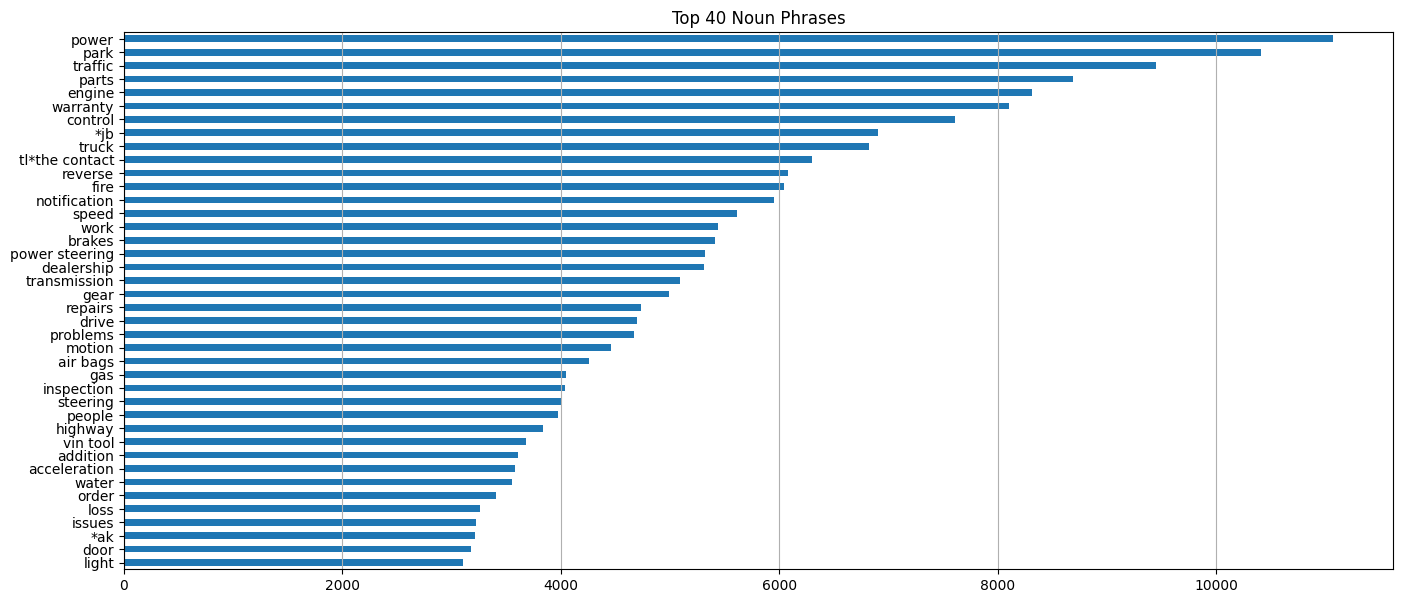

In [ ]:

fig, ax = plt.subplots(figsize=(18, 10))

# Plot the top 40 noun phrases as a horizontal bar chart on the axis 'ax'
noun_phrase_row_df['Noun Phrases'].value_counts().head(40).sort_values().plot(kind='barh', ax=ax)
ax.set_title('Top 40 Noun Phrases')  # Setting the title for the plot
ax.xaxis.grid(True)  # Adding the grid to the x-axis for better readability

# Adjust layout to prevent overlap
fig.tight_layout(pad=15)

plt.show()


In [20]:
modelNounPhraseList = noun_phrase_row_df[['VEHICLE MODEL', 'Noun Phrases']].values.tolist()
len(modelNounPhraseList)

9329

In [21]:
min_support_np = 100 / len(modelNounPhraseList)
min_support_np

0.010719262514738986

In [22]:
np_freqItemSet, np_rules = fpgrowth(modelNounPhraseList, minSupRatio=min_support_np, minConf=0.25)

In [18]:
from wordcloud import WordCloud

# Collect the nouns found in the association rules for <model>.
# Show the nouns in a word cloud, sized by the rule confidence.
def show_rules_for_model(rules, model):
    modelDict = {}
    for rule in rules:
        if model in rule[1]:
            noun=next(iter(rule[0]))
            if model.lower() not in noun: # we don't want to include the model name itself in the word cloud
                modelDict[noun] = int(rule[2]*1000)
    wc_a = WordCloud(width=700, height=200, background_color ='white',colormap='tab10', prefer_horizontal=0.9).generate_from_frequencies(modelDict)
    figure, ax1 = plt.subplots(ncols=1, figsize=(11,7))
    figure.tight_layout()
    ax1.imshow(wc_a, interpolation="bilinear")
    ax1.axis("off")
    ax1.title.set_text("Correlated terms for " + model)
    plt.show()

In [19]:
show_rules_for_model(np_rules, 'F-150')

ValueError: We need at least 1 word to plot a word cloud, got 0.

In [ ]:
subset_df = noun_phrase_row_df.iloc[:100000]


In [ ]:
modelNounPhraseList = subset_df[['VEHICLE MODEL', 'Noun Phrases']].values.tolist()

In [ ]:
modelNounPhraseList[:10]

[['EXPLORER', 'deep sleep mode'],
 ['F-350', '55 mph'],
 ['F-350', 'forsyth co.'],
 ['F-350', 'video'],
 ['ESCAPE', 'pch'],
 ['ESCAPE', 'gears'],
 ['FOCUS', 'july'],
 ['FOCUS', 'affinity'],
 ['FOCUS', 'p195/60r15 87t'],
 ['FOCUS', 'mentioned tires']]

In [ ]:

new_subset_df = noun_phrase_row_df.copy()

In [ ]:

new_subset_df.loc[:, 'Noun Phrases'] = new_subset_df['Noun Phrases'].apply(lambda x: [x])

# Group by 'VEHICLE MODEL' and aggregate 'Noun Phrases' into lists
grouped_df = new_subset_df.groupby('VEHICLE MODEL')['Noun Phrases'].sum().reset_index()

# Now 'grouped_df' has two columns: 'VEHICLE MODEL' and 'Noun Phrases' (which is a list of all phrases per model)


In [ ]:
grouped_df.head()

,VEHICLE MODEL,Noun Phrases
0,C-MAX,"[change volume, radio, engine light, $500.00 d..."
1,C-MAX ENERGI,"[10 mph, water, contact, main st, roswell]"
2,CROWN VICTORIA,"[intermittent stiffness, owner, lowers shafts,..."
3,E-350,"[spark plugs, cylinder heads, bad engineering ..."
4,E350,"[violent shaking, steering wheel]"


In [ ]:
grouped_df = grouped_df.copy()

In [ ]:
# Extracting just the lists of noun phrases for FP-growth
transactions = grouped_df['Noun Phrases'].tolist()
transactions = [[str(item) for item in transaction] for transaction in transactions]


In [ ]:
#transactions

In [ ]:
from mlxtend.frequent_patterns import fpgrowth, association_rules
from mlxtend.preprocessing import TransactionEncoder

# Transaction encoding
te = TransactionEncoder()
te_ary = te.fit(transactions).transform(transactions)
df = pd.DataFrame(te_ary, columns=te.columns_)

# Applying FP-growth
frequent_itemsets = fpgrowth(df, min_support=0.01, use_colnames=True)  # Adjust min_support as needed


In [ ]:
# Assuming you're using mlxtend or a similar library for FP-growth; adjust import as necessary
from mlxtend.frequent_patterns import fpgrowth
from mlxtend.preprocessing import TransactionEncoder



# Preparing data for FP-growth
# Aggregating noun phrases for each vehicle model into transactions


# Applying the FP-growth algorithm
te = TransactionEncoder()
te_ary = te.fit(transactions).transform(transactions)
df_transactions = pd.DataFrame(te_ary, columns=te.columns_)

# Finding the best support threshold
for min_support in [0.05, 0.03, 0.01, 0.005,0.0005,0.00005]:
    frequent_itemsets = fpgrowth(df_transactions, min_support=min_support, use_colnames=True)
    print(f'Min Support: {min_support}, Frequent Itemsets Found: {len(frequent_itemsets)}')




In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
from mlxtend.frequent_patterns import fpgrowth
from mlxtend.preprocessing import TransactionEncoder

# Assuming `modelNounPhraseList` is your prepared list of transactions
# For example: [['Airbag', 'Failure'], ['Brake', 'Issue'], ...]

# Convert transactions into a format suitable for MLxtend's FP-growth
te = TransactionEncoder()
te_ary = te.fit(modelNounPhraseList).transform(modelNounPhraseList)
df = pd.DataFrame(te_ary, columns=te.columns_)

# Define a range of support thresholds to test
support_thresholds = [0.05, 0.03, 0.01, 0.005,0.0005,0.00005]

# Dictionary to hold the number of itemsets for each support threshold
num_itemsets = {}

for support in support_thresholds:
    # Apply FP-growth
    frequent_itemsets = fpgrowth(df, min_support=support, use_colnames=True)

    # Store the number of itemsets found
    num_itemsets[support] = len(frequent_itemsets)

# Visualization
plt.figure(figsize=(10, 6))
plt.plot(list(num_itemsets.keys()), list(num_itemsets.values()), marker='o', linestyle='-', color='b')
plt.title('Impact of Support Threshold on Number of Itemsets')
plt.xlabel('Support Threshold')
plt.ylabel('Number of Itemsets')
plt.grid(True)
plt.xscale('log')  # Optional: Use logarithmic scale if the range of support thresholds is wide
plt.xticks(list(num_itemsets.keys()), labels=[str(s) for s in support_thresholds])  # Ensure x-ticks match the tested thresholds
plt.show()


TypeError: '<' not supported between instances of 'float' and 'str'

In [ ]:
# Adjust min_support based on your analysis of the printed results
# Then, generate association rules based on the chosen min_support
# from mlxtend.frequent_patterns import association_rules
# rules = association_rules(frequent_itemsets, metric="confidence", min_threshold=0.25)
# print(rules)

In [ ]:
# Aggregating noun phrases for each vehicle model into lists
aggregated_data = noun_phrase_row_df.groupby('VEHICLE MODEL')['Noun Phrases'].apply(list).reset_index()

# Convert to format suitable for FP-growth ([['Model1', 'phrase1', 'phrase2', ...], ['Model2', 'phrase1', 'phrase3', ...], ...])
modelNounPhraseList = aggregated_data.apply(lambda row: [row['VEHICLE MODEL']] + row['Noun Phrases'], axis=1).tolist()
